**Recommendation System**

---


Recommendation System for products on an e-commerce website like Amazon.com

In [0]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn import metrics
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DF=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Project_RecoSys/filtered_ratings_Electronics.csv',names=['userId','productId','ratings','timestamp'])

In [4]:
DF.head()

,userId,productId,ratings,timestamp
0,AT09WGFUM934H,594481813,3,1377907200
1,AT09WGFUM934H,B00005105L,5,1377475200
2,AT09WGFUM934H,B000068O1M,5,1384905600
3,AT09WGFUM934H,B000068O34,5,1384732800
4,AT09WGFUM934H,B000068O4J,5,1387238400


In [0]:
userGroup=DF['userId'].value_counts()
userGroup=userGroup.reset_index()

In [0]:
userGroup.rename(columns={'index':'userId',
                          'userId':'count'}, 
                 inplace=True)

Total Number of ratings given by users are as below

In [7]:
userGroup.head()

,userId,count
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406


A subset of data is considered where every user who has rated more than 70 times.

In [0]:
userGroup=userGroup[userGroup['count']>70]

In [0]:
dataFinal=pd.merge(left=DF,right=userGroup, left_on='userId', right_on='userId')

In [10]:
dataFinal.count()

userId       75352
productId    75352
ratings      75352
timestamp    75352
count        75352
dtype: int64

In [11]:
dataFinal['ratings'].value_counts()

5    41780
4    20189
3     7336
2     3161
1     2886
Name: ratings, dtype: int64

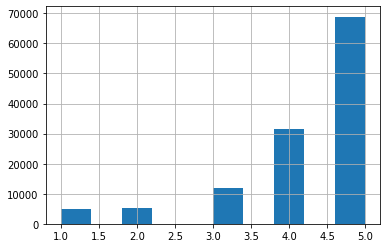

In [12]:
DF["ratings"].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12dbd99c88>,
      dtype=object)

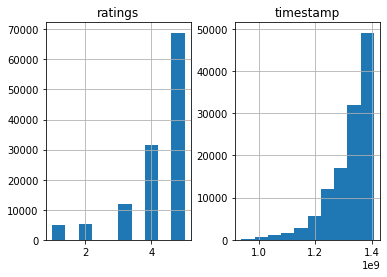

In [13]:
DF.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12db834048>,
      dtype=object)

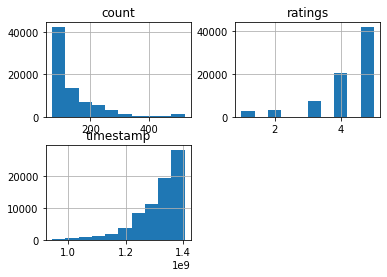

In [14]:
dataFinal.hist()

**Recommending Products based of top mean ratings**

In [15]:
dataFinal.groupby('productId')['ratings'].mean().sort_values(ascending = False).head(10)

productId
B00LKG1MC8    5.0
B002IPHA1W    5.0
B002IKKFIC    5.0
B002IKLJU0    5.0
B002IKLJUU    5.0
B002IL30I8    5.0
B002IL8XRQ    5.0
B002IORQ6W    5.0
B002IPH9ZY    5.0
B002IPHA3U    5.0
Name: ratings, dtype: float64

**Recommending Products based on most number of ratings**

In [16]:
dataFinal.groupby('productId')['ratings'].count().sort_values(ascending = False).head(10)

productId
B0088CJT4U    131
B003ES5ZUU    102
B002R5AM7C     98
B000N99BBC     98
B00829TIEK     95
B008DWCRQW     91
B007WTAJTO     82
B004CLYEDC     77
B00829THK0     76
B004T9RR6I     70
Name: ratings, dtype: int64

**Creating a new dataframe with mean rating and rating count.**

In [17]:
rating_mean_count = pd.DataFrame(dataFinal.groupby('productId')['ratings'].mean()).sort_values(by=['productId'])
rating_mean_count['rating_counts'] = pd.DataFrame(dataFinal.groupby('productId')['ratings'].count()).sort_values(by=['productId'])
rating_mean_count.head()

,ratings,rating_counts
productId,,
1400501466,2.000000,2
1400501776,4.000000,1
1400532620,1.000000,1
1400532655,2.666667,3
1400599997,3.000000,2


**Min rating set to 5.**

In [0]:
min_rating = 5

In [0]:
mean_rating_dataset = np.mean(rating_mean_count.ratings.values)

**Defining Weighted Rating.**

In [0]:
def weighted_rating(rating_mean_count, min_votes, mean_rating_dataset):
    weighted_rating = list()
    V = rating_mean_count.rating_counts.values
    R = rating_mean_count.ratings.values
    for v, r in zip(V, R):
        if v < 5:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_votes))*r + (min_votes/(v+min_votes))*mean_rating_dataset)
    return(weighted_rating)

In [0]:
rating_mean_count['weighted_rating'] = weighted_rating(rating_mean_count, min_rating, mean_rating_dataset)

In [22]:
rating_mean_count.weighted_rating.sort_values(ascending = False).head(10)

productId
B0052SCU8U    4.884881
B003ES5ZUU    4.860616
B001TH7GUU    4.852893
B00BQ4F9ZA    4.830550
B000067RT6    4.829824
B0036Q7MV0    4.824498
B00ISFNSBW    4.822089
B00HZWJGS8    4.813617
B001TH7T2U    4.803438
B0000BZL1P    4.802865
Name: weighted_rating, dtype: float64

In [23]:
pip install scikit-surprise

In [0]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split

In [0]:
dataFinal.rename(columns={'productId':'movieId', 'userId':'userId', 'ratings':'rating'}, inplace=True)

In [0]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(dataFinal[['userId', 'movieId', 'rating']], reader)

In [0]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

In [28]:
np.shape(testset)

(22606, 3)

In [29]:
algo = SVD()
algo.fit(trainset)

In [0]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [0]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [32]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.3941


0.394099266847476

In [33]:
accuracy.mae(predictions, verbose=True)

MAE:  0.3048


0.30481151789074007

In [34]:
get_top_n(predictions,5)

defaultdict(list,
            {'A100UD67AHFODS': [('B00FZ9SMVU', 5),
              ('B006W8U2MU', 5),
              ('B000N99BBC', 5),
              ('B003UH0Z9Q', 5),
              ('B00BQ4F9ZA', 5)],
             'A100WO06OQR8BQ': [('B000M2TAN4', 4.775058195189781),
              ('B00CKAOJA0', 4.757197541319414),
              ('B00176IJFO', 4.661091346714998),
              ('B004XJPAGI', 4.61026508062527),
              ('B00029HOCG', 4.572034879274039)],
             'A105TOJ6LTVMBG': [('B00077AA5Q', 4.66149636469488),
              ('B000ANCPNM', 4.510534758650508),
              ('B0052SCU8U', 4.4735845434848684),
              ('B000N99BBC', 4.468255741057967),
              ('B004XC6GJ0', 4.461508663824077)],
             'A10NMELR4KX0J6': [('B001TH7GUU', 4.988330907353651),
              ('B000N99BBC', 4.914666532311724),
              ('B006W8U2MU', 4.886386838687673),
              ('B002TMRZOQ', 4.885204405029251),
              ('B003CFATT2', 4.829241849792073)],
       

Top Five Recommended ProductIDs with their ratings for each UserID is as listed above.
With RMSE as 0.39 and MAE as 0.30